# Pneumonia detection on MRI images using Convolutional Neural Networks 

## Load packages

In [2]:
!pip install focal-loss

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from focal_loss import BinaryFocalLoss

import tensorflow as tf

# Loading Data

In [4]:
### Defining Load Function
size=180
CodeLabel = {"NORMAL":0, "PNEUMONIA":1}

def load_data(main_dir):
    X = []
    y = []
    for sub_dir in os.listdir(main_dir):
        inner_dir=os.path.join(main_dir,sub_dir)
        for i in os.listdir(inner_dir):
            img=cv2.imread(os.path.join(inner_dir,i),0)
            img=cv2.resize(img,(size,size))
            X.append(img)
            y.append(CodeLabel[sub_dir])
    data = zip(X,y)
    zipped_data = list(data)
    random.shuffle(zipped_data)
    unzipped_data = [list(t) for t in zip(*zipped_data)]
    X_new = unzipped_data[0]
    y_new = unzipped_data[1]


    return X_new,y_new
            

In [5]:
### Reading data
train_X, train_y =load_data('../input/chest-xray-pneumonia/chest_xray/train')
val_X, val_y  = load_data('../input/chest-xray-pneumonia/chest_xray/val')
test_X, test_y  = load_data('../input/chest-xray-pneumonia/chest_xray/test')

In [6]:
### Checking Data Size
print(len(train_X), len(train_y))
print(len(val_X), len(val_y))
print(len(test_X), len(test_y))

5216 5216
16 16
624 624


# Chaning number of samples in the  training and validation dataset
It looks like validation dataset is not big enough. I am going to pick random data from training dataset, append to validation dataset and remove from traning (validation dataset to be at least 15% of training dataset)

In [7]:
### Random indexes
random_ix = []

while len(random_ix)<784:
    ix = random.randint(0, len(train_X))
    if ix not in random_ix:
        random_ix.append(ix)
#print(random_ix)
print(len(random_ix))

784


In [8]:
val_X_new = [train_X[i] for i in random_ix]
val_y_new = [train_y[i] for i in random_ix]

val_X_new = val_X_new+val_X
val_y_new = val_y_new+val_y

print("New validation dataset size:")
print(len(val_X_new))

train_X_new = np.delete(train_X, random_ix, axis=0)
train_y_new = np.delete(train_y, random_ix, axis=0)

print("New training dataset size:")
print(len(train_X_new))

New validation dataset size:
800
New training dataset size:
4432


In [9]:
### Cheking size by the class
normal=[]
pneumonia=[]
for ix in range(len(train_X_new)):
    if train_y_new[ix]==0:
        normal.append(train_X_new[ix])
    else:
        pneumonia.append(train_X_new[ix]) 
        
print("Pneumonia samples in training dataset:", len(pneumonia))
print("Normal samples in training dataset:", len(normal))

normal_val=[]
pneumonia_val=[]
for ix in range(len(val_X_new)):
    if val_y_new[ix]==0:
        normal_val.append(val_X_new[ix])
    else:
        pneumonia_val.append(val_X_new[ix]) 
        
print("Pneumonia samples in validation dataset:", len(pneumonia_val))
print("Normal samples in validation dataset:", len(normal_val))

normal_test=[]
pneumonia_test=[]
for ix in range(len(test_X)):
    if test_y[ix]==0:
        normal_test.append(test_X[ix])
    else:
        pneumonia_test.append(test_X[ix]) 
        
print("Pneumonia samples in testing dataset", len(pneumonia_test))
print("Normal samples in testing dataset:", len(normal_test))

Pneumonia samples in training dataset: 3305
Normal samples in training dataset: 1127
Pneumonia samples in validation dataset: 578
Normal samples in validation dataset: 222
Pneumonia samples in testing dataset 390
Normal samples in testing dataset: 234


# Show Sample Images

In [10]:
def show_sample(Data, Label):
    plt.figure(figsize=(10,10))
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(Data[i], cmap='gray')
        if Label==1:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

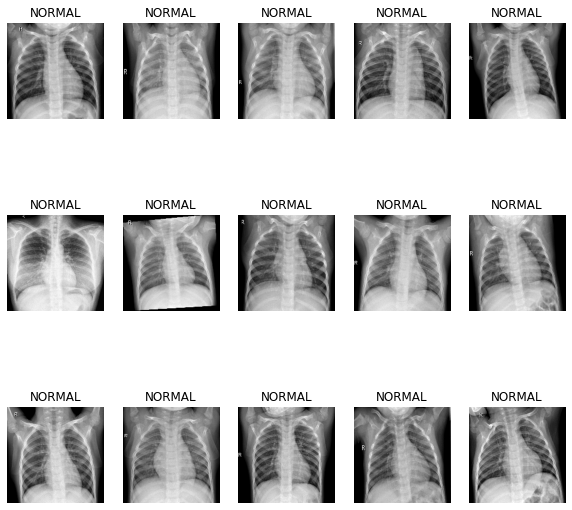

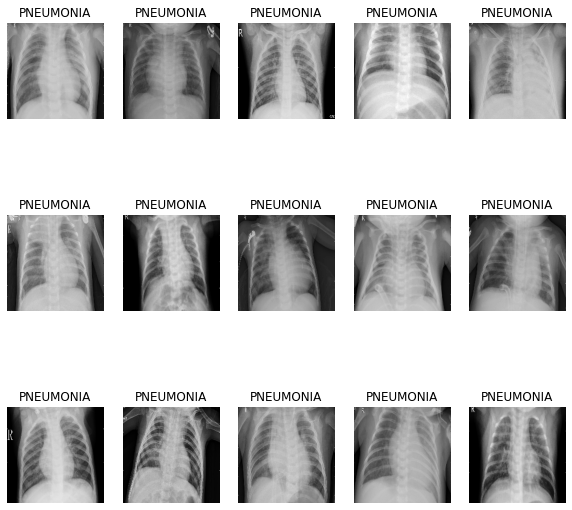

In [12]:
show_sample(normal,0)
show_sample(pneumonia,1)

# Balancing classes

We have less plenuomonia cases; especially in training dataset. This problem can be tackled by altering the class wight and using focal loss to down weights the correctly classified examples (majority class). Other approach would beto utilise oversampling and undersampling approaches.


Below **SMOTE** oversampling technique.

In [13]:
### Preparing Data
train_X=np.array(train_X_new)/255
val_X=np.array(val_X_new)/255
test_X=np.array(test_X)/255

train_y=np.array(train_y_new)
val_y=np.array(val_y_new)
test_y=np.array(test_y)

### Smote on training data 
sm = SMOTE(random_state=42)

### Preparing Data
train_X_orig_shape = train_X.shape
val_X_orig_shape =val_X.shape

#### Reshape
train_X_reshaped = np.reshape(train_X, (train_X.shape[0],train_X.shape[1]* train_X.shape[2]))
val_X_reshaped = np.reshape(val_X, (val_X.shape[0],val_X.shape[1]* val_X.shape[2]))

#### Smote
train_X_smote,train_y_smote= sm.fit_resample(train_X_reshaped,train_y)

sm = SMOTE(random_state=42)
val_X_smote,val_y_smote= sm.fit_resample(val_X_reshaped,val_y)

###Reshape back to original
train_X_smote_reshaped = train_X_smote.reshape(train_X_smote.shape[0], -1)
train_X_smote_orig = np.reshape(train_X_smote_reshaped, (train_X_smote_reshaped.shape[0],train_X_orig_shape[1],train_X_orig_shape[2]))

val_X_smote_reshaped = val_X_smote.reshape(val_X_smote.shape[0], -1)
val_X_smote_orig = np.reshape(val_X_smote_reshaped, (val_X_smote_reshaped.shape[0],val_X_orig_shape[1],val_X_orig_shape[2]))

###Final reshape to 4D 
train_X_smote=train_X_smote_orig.reshape(-1,size,size,1)
train_X=train_X.reshape(-1,size,size,1)
val_X=val_X.reshape(-1,size,size,1)
val_X_smote= val_X_smote_orig.reshape(-1,size,size,1)
test_X=test_X.reshape(-1,size,size,1)

In [14]:
### Final data size
print("Original training set size:")
print(len(train_X), len(train_y))
print("Smote augmented training set size:")
print(len(train_X_smote), len(train_y_smote))
print("Validation set size:")
print(len(val_X), len(val_y))
print("Smote augmented validation set size:")
print(len(val_X_smote), len(val_y_smote))
print("Test set size:")
print(len(test_X), len(test_y))

Original training set size:
4432 4432
Smote augmented training set size:
6610 6610
Validation set size:
800 800
Smote augmented validation set size:
1156 1156
Test set size:
624 624


In [15]:
normal_train_smote=[]
pneumonia_train_smote=[]
for ix in range(len(train_X_smote)):
    if train_y_smote[ix]==0:
        normal_train_smote.append(train_X_smote[ix])
    else:
        pneumonia_train_smote.append(train_X_smote[ix]) 
        
print("Pneumonia samples in training dataset after SMOTE:", len(pneumonia_train_smote))
print("Normal samples in training dataset after SMOTE:", len(normal_train_smote))

Pneumonia samples in training dataset after SMOTE: 3305
Normal samples in training dataset after SMOTE: 3305


In [16]:
normal_val_smote=[]
pneumonia_val_smote=[]
for ix in range(len(val_X_smote)):
    if val_y_smote[ix]==0:
        normal_val_smote.append(val_X_smote[ix])
    else:
        pneumonia_val_smote.append(val_X_smote[ix]) 
        
print("Pneumonia samples in training dataset after SMOTE:", len(pneumonia_val_smote))
print("Normal samples in training dataset after SMOTE:", len(normal_val_smote))

Pneumonia samples in training dataset after SMOTE: 578
Normal samples in training dataset after SMOTE: 578


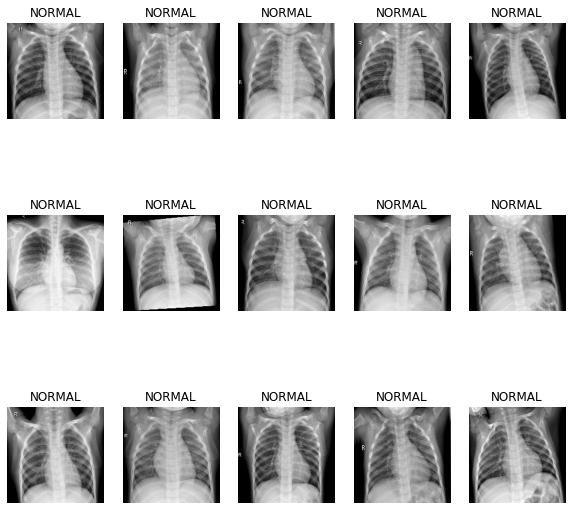

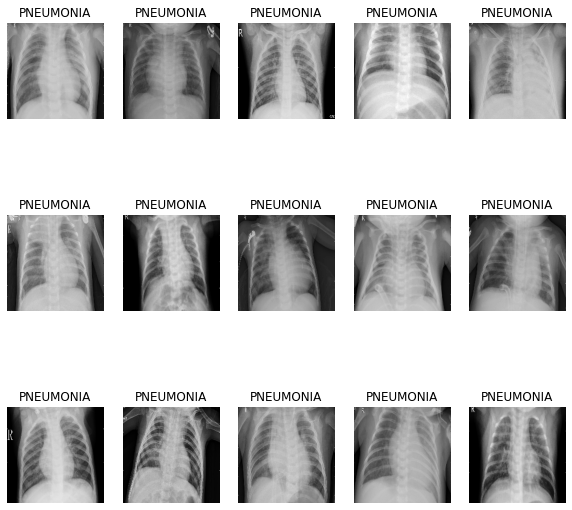

In [17]:
# Show Images
show_sample(normal_train_smote,0)
show_sample(pneumonia_train_smote,1)

**Other Steps to icrease number of samples and direct the unbalanced class problem:**

* Image Generator
* Focal Loss custom function
* Class balancing
* Callback list - early stopping & reducing learning rate

In [18]:
### Generating New Images
image_gen=ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [19]:
#### Cnn architecture
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.compile(optimizer = "adam" , loss = BinaryFocalLoss(gamma=2) , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0

In [21]:
weights = compute_class_weight('balanced', np.unique(train_y), train_y)
new_weights = dict(zip( np.unique(train_y), weights))
print(new_weights)

{0: 1.966282165039929, 1: 0.670499243570348}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### First Experiment 

* Relatively deep ConvNet
* Binary cross entropy loss function
* Reduced learning rate on plateu
* Proportional to class representaion weigth
* Original data (without synthetic sampling)
* 20 epochs; without early stopping


In [22]:
## test 1 - adjusted weight and no smote
history = model.fit(image_gen.flow(train_X,train_y, batch_size = 25),epochs = 20 ,validation_data = image_gen.flow(val_X, val_y),class_weight=new_weights,  callbacks = [reduce_lr])

Epoch 1/20
178/178 [==============================] - 17s 78ms/step - loss: 1.1765 - accuracy: 0.7311 - val_loss: 25.1974 - val_accuracy: 0.7225
Epoch 2/20
178/178 [==============================] - 13s 73ms/step - loss: 0.3961 - accuracy: 0.8559 - val_loss: 1.9365 - val_accuracy: 0.7225
Epoch 3/20
178/178 [==============================] - 13s 75ms/step - loss: 0.3713 - accuracy: 0.8532 - val_loss: 1.2741 - val_accuracy: 0.7237
Epoch 4/20
178/178 [==============================] - 13s 72ms/step - loss: 0.2805 - accuracy: 0.8841 - val_loss: 0.9332 - val_accuracy: 0.7437
Epoch 5/20
178/178 [==============================] - 13s 76ms/step - loss: 0.2722 - accuracy: 0.8897 - val_loss: 0.3630 - val_accuracy: 0.8537
Epoch 6/20
178/178 [==============================] - 13s 75ms/step - loss: 0.2264 - accuracy: 0.9086 - val_loss: 2.0843 - val_accuracy: 0.3713
Epoch 7/20
178/178 [==============================] - 13s 72ms/step - loss: 0.2679 - accuracy: 0.8950 - val_loss: 3.6861 - val_accuracy

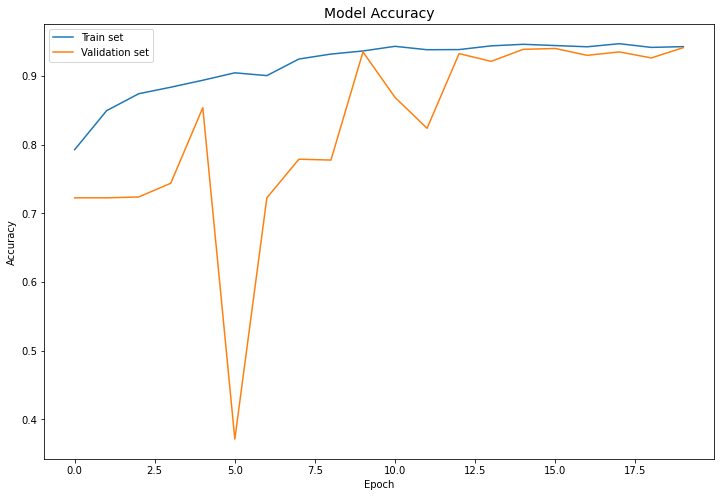

In [23]:
plt.subplots(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='upper left')
plt.show()

Accuracy for validations is increasing with epochs (apart for one significant drop). In the final training epocj validation accuracy catch up with training accuracy.

In [24]:
prediction=model.predict_classes(test_X)

print("Test Accuracy: {:.2f}".format(accuracy_score(prediction, test_y)))

print("Clasifcation Report:")
print(classification_report(prediction, test_y))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Accuracy: 0.90
Clasifcation Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       217
           1       0.94      0.90      0.92       407

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.89       624
weighted avg       0.91      0.90      0.90       624



<AxesSubplot:>

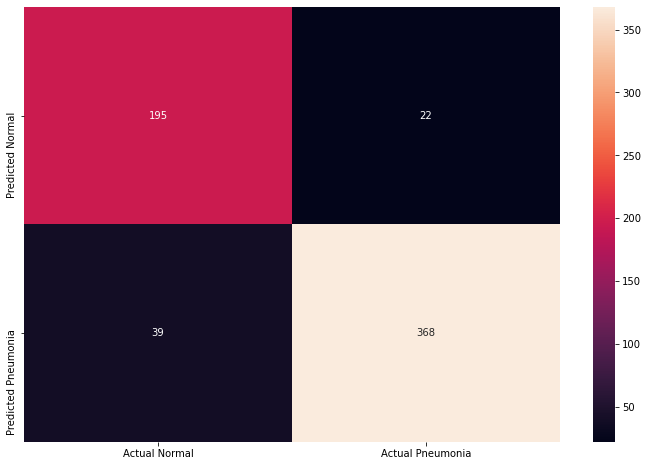

In [25]:
plt.subplots(figsize=(12,8))
cm = pd.DataFrame(data=confusion_matrix(prediction, test_y, labels=[0, 1]),columns=["Actual Normal", "Actual Pneumonia"],
index=["Predicted Normal", "Predicted Pneumonia"])

sns.heatmap(cm,annot=True,fmt="d")

Accuracy (number of correct prediction) is 0.9. Good number of corretly predicted smples. Number of False Postives is double  the number of False Negative (and FN should worry us more). Since Test sample have not been balanced (more pneumonia sample) F1 score 0.9 indicates that model works well with both classes.

### Second Experiment 

* As above - with early stopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2,  verbose=1,factor=0.25, min_lr=0.000001)

In [40]:
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.compile(optimizer = "adam" , loss = BinaryFocalLoss(gamma=2) , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 180, 180, 64)      640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 90, 90, 32)        18464     
_________________________________________________________________
dropout_12 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 45, 45, 32)       

In [34]:
## test 1 - adjusted weight and no smote
history = model.fit(image_gen.flow(train_X,train_y, batch_size = 25),epochs = 20 ,validation_data = image_gen.flow(val_X, val_y),class_weight=new_weights,  callbacks = [early_stop, reduce_lr])

Epoch 1/20
178/178 [==============================] - 14s 76ms/step - loss: 1.2398 - accuracy: 0.7660 - val_loss: 5.2529 - val_accuracy: 0.7225
Epoch 2/20
178/178 [==============================] - 14s 79ms/step - loss: 0.3645 - accuracy: 0.8447 - val_loss: 7.7093 - val_accuracy: 0.7225
Epoch 3/20
178/178 [==============================] - 13s 74ms/step - loss: 0.3335 - accuracy: 0.8641 - val_loss: 18.3167 - val_accuracy: 0.7225

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/20
178/178 [==============================] - 14s 77ms/step - loss: 0.2742 - accuracy: 0.8741 - val_loss: 5.3073 - val_accuracy: 0.7225
Epoch 5/20
178/178 [==============================] - 13s 74ms/step - loss: 0.2243 - accuracy: 0.9055 - val_loss: 0.2726 - val_accuracy: 0.8938
Epoch 6/20
178/178 [==============================] - 13s 75ms/step - loss: 0.2167 - accuracy: 0.9123 - val_loss: 2.3024 - val_accuracy: 0.7400
Epoch 7/20
178/178 [==============================] - 

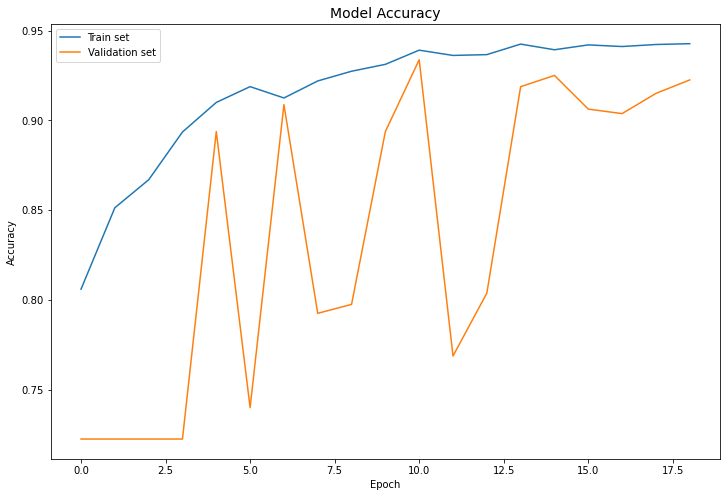

In [35]:
plt.subplots(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='upper left')
plt.show()

In [36]:
prediction=model.predict_classes(test_X)

print("Test Accuracy: {:.2f}".format(accuracy_score(prediction, test_y)))
print("Clasifcation Report:")
print(classification_report(prediction, test_y))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Accuracy: 0.88
Clasifcation Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       206
           1       0.94      0.88      0.91       418

    accuracy                           0.88       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.89      0.88      0.88       624



<AxesSubplot:>

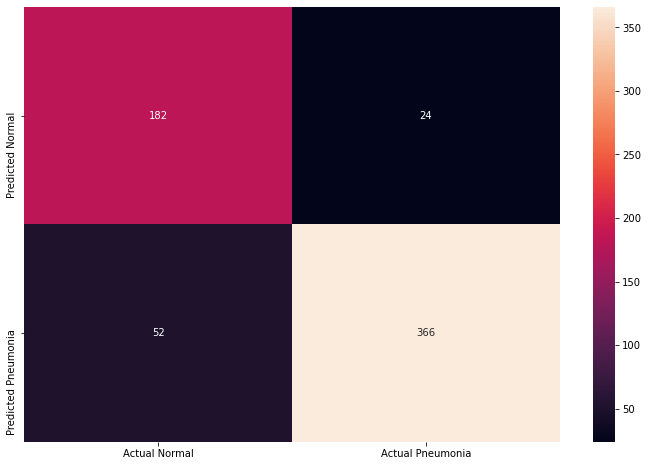

In [37]:
plt.subplots(figsize=(12,8))
cm = pd.DataFrame(data=confusion_matrix(prediction, test_y, labels=[0, 1]),columns=["Actual Normal", "Actual Pneumonia"],
index=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

This has worked worse - validation accuracy have not beenstable across epochs. We have worse accuracy and F1 score on the test data.

### Third Experiment 

* Same class weigths
* SMOTE synthetic sampling
* 20 epochs; without early stopping

In [41]:
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#model.compile(optimizer = "adam" , loss = BinaryFocalLoss(gamma=2) , metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 180, 180, 64)      640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 90, 90, 32)        18464     
_________________________________________________________________
dropout_15 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 45, 45, 32)       

In [42]:
### Test 3 SMOTE
history = model.fit(image_gen.flow(train_X_smote,train_y_smote, batch_size = 25),epochs = 20 ,validation_data = image_gen.flow(val_X_smote, val_y_smote),  callbacks = [reduce_lr])

Epoch 1/20
265/265 [==============================] - 21s 78ms/step - loss: 1.0737 - accuracy: 0.7371 - val_loss: 6.1358 - val_accuracy: 0.5000
Epoch 2/20
265/265 [==============================] - 20s 77ms/step - loss: 0.2878 - accuracy: 0.8829 - val_loss: 4.7297 - val_accuracy: 0.5000
Epoch 3/20
265/265 [==============================] - 19s 73ms/step - loss: 0.2564 - accuracy: 0.9059 - val_loss: 2.7484 - val_accuracy: 0.5035
Epoch 4/20
265/265 [==============================] - 20s 76ms/step - loss: 0.2237 - accuracy: 0.9168 - val_loss: 1.2430 - val_accuracy: 0.5303
Epoch 5/20
265/265 [==============================] - 19s 72ms/step - loss: 0.2397 - accuracy: 0.9081 - val_loss: 0.5865 - val_accuracy: 0.7379
Epoch 6/20
265/265 [==============================] - 20s 75ms/step - loss: 0.1877 - accuracy: 0.9307 - val_loss: 4.4774 - val_accuracy: 0.4991
Epoch 7/20
265/265 [==============================] - 20s 75ms/step - loss: 0.2050 - accuracy: 0.9245 - val_loss: 1.9282 - val_accuracy:

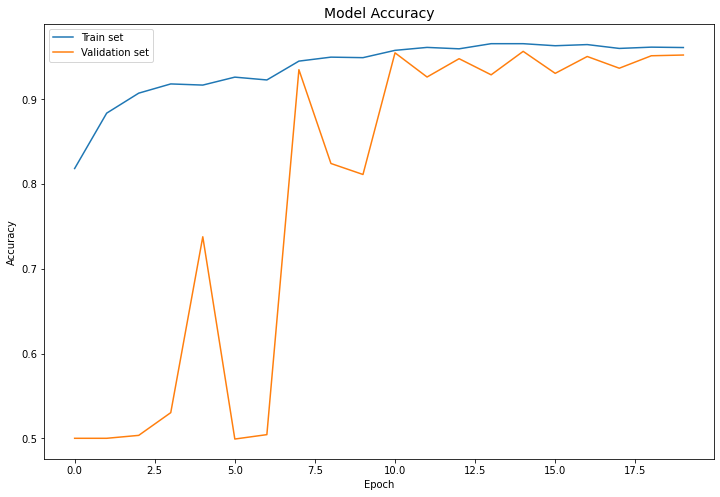

In [43]:
plt.subplots(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=14)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train set', 'Validation set'], loc='upper left')
plt.show()

In [44]:
prediction=model.predict_classes(test_X)

print("Test Accuracy: {:.2f}".format(accuracy_score(prediction, test_y)))
print("Clasifcation Report:")
print(classification_report(prediction, test_y))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test Accuracy: 0.89
Clasifcation Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       198
           1       0.96      0.88      0.91       426

    accuracy                           0.89       624
   macro avg       0.86      0.89      0.88       624
weighted avg       0.90      0.89      0.89       624



<AxesSubplot:>

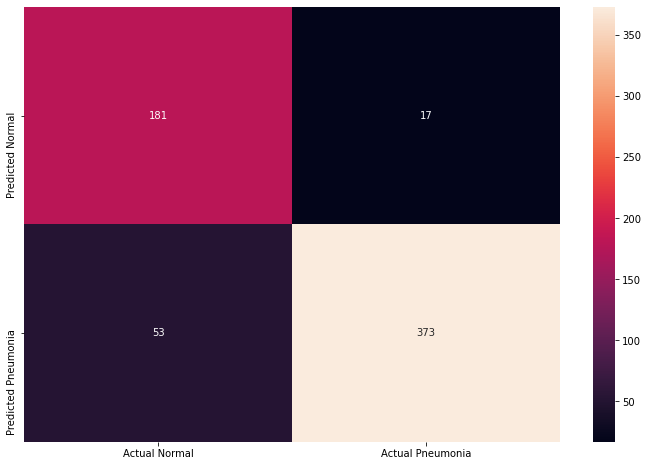

In [45]:
plt.subplots(figsize=(12,8))
cm = pd.DataFrame(data=confusion_matrix(prediction, test_y, labels=[0, 1]),columns=["Actual Normal", "Actual Pneumonia"],
index=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

The model above have almost same accuracy and F1 score on test data as the first experiment (1% worse) and is even slightly better in minimising number of False Negative (Pneumonia predicted as normal).